In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch
import torch.nn as nn
from glob import glob
from os.path import expanduser, join, basename, dirname
import xarray as xr
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import product
from torch.utils.data import TensorDataset, DataLoader
from astra.torch.models import EfficientNetClassifier,EfficientNet_B0_Weights
from astra.torch.utils import train_fn

import torchvision.models as models
from astra.torch.metrics import accuracy_score, f1_score, precision_score, recall_score,classification_report

In [2]:
# Load the saved tensors
loaded_data1 = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/data.pt")

# Access the tensors
index = loaded_data1['index']
images = loaded_data1['images']
labels = loaded_data1['labels']
#print shape of tensors
images = images / 255
    # mean normalize
images = (images - images.mean(dim=(0, 2, 3), keepdim=True)) / images.std(dim=(0, 2, 3), keepdim=True)
print(images.shape)
print(labels.shape)
#print the labels
print(labels)
#count the number of unique labels
# count the number of 1s and 0s
unique, counts = np.unique(labels, return_counts=True)
print(dict(zip(unique, counts)))

# subset_labels = labels[:17000]   
# num_ones = np.count_nonzero(subset_labels == 1)
# num_zeros = np.count_nonzero(subset_labels == 0)

# print(f"Number of 1s(train ): {num_ones}")
# print(f"Number of 0s(train): {num_zeros}")

torch.Size([25500, 3, 224, 224])
torch.Size([25500])
tensor([0, 0, 0,  ..., 1, 0, 0], dtype=torch.uint8)
{0: 23803, 1: 1697}


In [3]:
train_dataset = TensorDataset(images, labels)
train_loader = DataLoader(train_dataset, batch_size=254, shuffle=True)



In [4]:
# Load the saved tensors
loaded_data = torch.load("/home/rishabh.mondal/Brick-Kilns-project/albk_rishabh/tensor_data/test_data.pt")

# Access the tensors
index = loaded_data['index']
images1 = loaded_data['images']
labels1 = loaded_data['labels']
#print shape of tensors
images1 = images1 / 255
    # mean normalize
images1 = (images1 - images1.mean(dim=(0, 2, 3), keepdim=True)) / images1.std(dim=(0, 2, 3), keepdim=True)
print(images1.shape)
print(labels1.shape)
#print the labels
print(labels1)
#count the number of unique labels
# count the number of 1s and 0s
unique, counts = np.unique(labels1, return_counts=True)
print(dict(zip(unique, counts)))

subset_labels = labels1  
num_ones = np.count_nonzero(subset_labels == 1)
num_zeros = np.count_nonzero(subset_labels == 0)

print(f"Number of 1s(train ): {num_ones}")
print(f"Number of 0s(train): {num_zeros}")

torch.Size([10025, 3, 224, 224])
torch.Size([10025])
tensor([0, 0, 0,  ..., 0, 0, 0], dtype=torch.uint8)
{0: 8983, 1: 1042}
Number of 1s(train ): 1042
Number of 0s(train): 8983


In [5]:

test_dataset = TensorDataset(images1, labels1)
test_loader = DataLoader(test_dataset, batch_size=254, shuffle=False)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
train_model = EfficientNetClassifier(
    models.efficientnet_b0,EfficientNet_B0_Weights, n_classes=2, activation=nn.ReLU(), dropout=0.1
).to(device)

iter_losses, epoch_losses = train_fn(
    train_model,
    nn.CrossEntropyLoss(),
    dataloader=train_loader,
    lr=3e-4,
    epochs=100,
    verbose=True,
    wandb_log=False,
)

/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Loss: 0.00103105: 100%|██████████| 100/100 [1:08:30<00:00, 41.10s/it]


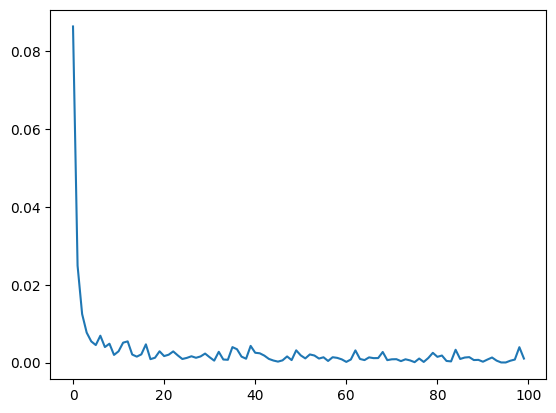

In [9]:
plt.plot(epoch_losses)

In [12]:
with torch.no_grad():
    pred_classes =train_model.predict_class(
        dataloader=test_loader, batch_size=254, verbose=True
    ).to(device)

test_labels = labels1.to(device)
print("Accuracy: ", accuracy_score(pred_classes,test_labels))
print("Precision: ", precision_score(pred_classes,test_labels))
print("Recall: ", recall_score(pred_classes,test_labels))
print("F1: ", f1_score(pred_classes,test_labels))
print("classification report: ", classification_report(pred_classes,test_labels))

100%|██████████| 40/40 [00:03<00:00, 10.33it/s]

Accuracy:  tensor(0.9440, device='cuda:0')
Precision:  tensor(0.9097, device='cuda:0')
Recall:  tensor(0.5125, device='cuda:0')
F1:  tensor(0.6556, device='cuda:0')
classification report:  {'accuracy': tensor(0.9440, device='cuda:0'), 'precision': tensor(0.9097, device='cuda:0'), 'recall': tensor(0.5125, device='cuda:0'), 'f1': tensor(0.6556, device='cuda:0')}


: 